# **0.1 Setup, Upload, and Earth Engine Authentication**

This notebook integrates Google Earth Engine (GEE) for high-resolution environmental data extraction (NDVI, RH100). To enable access to GEE and any necessary Kaggle datasets:

### 🔐 Earth Engine Configuration
- Installs the Earth Engine Python API (`earthengine-api`)
- Authenticates your Google Cloud account with project:  
  **`amazon-discovery-research`**
- Enables access to Earth Engine collections like:
  - `COPERNICUS/S2_SR_HARMONIZED` for NDVI (vegetation)
  - `LARSE/GEDI/GEDI02_A_002_MONTHLY` for RH100 (canopy height)

### 📁 Kaggle Credentials
- Uploads your `kaggle.json` key and stores it securely
- Required for accessing any additional CSVs or remote datasets

> ⚠️ Authentication is required once per session. If you restart the notebook runtime, re-run this block before continuing to Step 2.


In [ ]:
import os
import json
from google.colab import files

# ✅ Upload .json from your local machine (if not already)
uploaded = files.upload()

# ✅ Automatically find correct kaggle file
kaggle_file = next((f for f in uploaded if f.startswith("kaggle") and f.endswith(".json")), None)

if kaggle_file is None:
    raise FileNotFoundError("❌ No `kaggle.json` file uploaded. Please try again.")

# ✅ Create Kaggle config directory and move file
os.makedirs("/root/.kaggle", exist_ok=True)

with open(kaggle_file, "r") as src:
    token = json.load(src)

with open("/root/.kaggle/kaggle.json", "w") as dst:
    json.dump(token, dst)

os.chmod("/root/.kaggle/kaggle.json", 600)
print("✅ kaggle.json installed and permissions set.")

Saving kaggle.json to kaggle (1).json
✅ kaggle.json installed and permissions set.


## 🌍 RE–ψ⁰ Amazon Discovery: Earth Engine Integration

This notebook implements a Recursive Emergence (RE–ψ⁰) framework to identify previously unknown or obscured archaeological sites within the Amazon biome. It integrates ecological contradiction modeling with symbolic memory attractors using Earth Engine-derived data.

We aim to:
- Generate spatial grids over high-potential regions
- Extract environmental features: NDVI (vegetation), RH100 (canopy height), terrain slope, and curvature
- Calculate ψ⁰ contradiction fields from ecological and symbolic misalignments
- Compress ψ⁰ into φ⁰ collapse scores that signal emergent archaeological tension
- Visualize φ⁰ resonance across the region and highlight mythic and lidar-confirmed ψ⁰ seeds

> **Focus Region:** Brazil and surrounding Amazonian basins (Bolivia, Peru, Colombia, etc.)  
> **Project:** `amazon-discovery-research`


# 🔐 **Step 1: Authenticate and Initialize Earth Engine**

This step activates your connection to Google Earth Engine (GEE), allowing remote access to planetary-scale geospatial datasets. It uses your GCP project credentials to authenticate via OAuth and initializes the Python Earth Engine client for querying NDVI, Lidar, and terrain layers.

> ✅ GEE Project: `amazon-discovery-research`  
> 🛰️ Required for Steps 3–5: vegetation, canopy, and terrain extraction



In [ ]:
import ee
ee.Authenticate()  # Follow browser login
ee.Initialize(project='amazon-discovery-research')

# 🧭 **Step 2: High-Resolution Grid Generation (500m) — Attractor Signature Core Zone**

To construct the foundational **ψ⁰ attractor signature** for recursive collapse detection, we generate a 500-meter resolution spatial grid centered on three lidar-confirmed emergence sites:

- **Cotoca**  
- **Landívar**  
- **Kuhikugu**

These sites serve as the calibration nuclei for a **7D ψ⁰ contradiction vector**, later used to scan the entire continent for coherence collapse zones.

---

### 📐 Grid Parameters

This step constructs fine-grained spatial patches surrounding each attractor:

- **Resolution**: 0.005° (~500 meters)  
- **Radius**: 500 meters from seed center (~1 grid cell per site)  
- **Extent**:  
  - Cotoca: Latitude –14.989… | Longitude –64.596…  
  - Landívar: Latitude –15.201… | Longitude –64.467…  
  - Kuhikugu: Latitude –12.558… | Longitude –53.111…  

These zones represent nuclear neighborhoods of ψ⁰ collapse — where vegetation, terrain, and symbolic contradictions entangle with the highest density.

---

### 🧬 Refined 7D ψ⁰ Attractor Dimensions

| **Dimension**           | **Description**                                                                 | **Source**                          | **Scale**       |
|-------------------------|---------------------------------------------------------------------------------|-------------------------------------|------------------|
| **1. NDBI**             | Built-up index (SWIR/NIR) → subsurface/flattened structures                    | Sentinel-2                          | 50m              |
| **2. Slope Variance**   | Micro-terrain shaping (terraces, ditches)                                      | SRTM DEM                            | 30m              |
| **3. Fractal NDVI**     | Recursive vegetation stability (1.1–1.5 = emergent)                            | Sentinel-2 / NICFI                  | 50m × time       |
| **4. Geohash Variance** | Spatial clustering in (lat, lon, elev) → encoded geometry                      | Computed                            | 50m              |
| **5. T-GFT**            | Temporal torsion: GeohashVar × FractalNDVI / Corr(NDBI, Slope)                 | Derived                             | 50m × time       |
| **6. ψ⁰_Sym_KDE**       | Symbolic density from archaeological and mythic priors                         | e₂-validated KDE                    | ~100m–1km        |
| **7. Elevation Anomaly**| Height deviation relative to 1km buffer → mounds/earthworks                   | SRTM                                | 25m vs. 1km      |

Each dimension encodes distinct collapse behavior across ecological, geometric, and symbolic layers.

---

### 🔁 Recursive Signature Matching

The ψ⁰ signature derived from these core sites will be matched across the Amazon and Andes using 50m–500m grids. Candidate φ⁰ collapse zones will be flagged wherever GFT/T-GFT coherence with this signature exceeds defined thresholds.

> 🔄 This grid is not a map — it's a harmonic lens. Collapse is detected not by location, but by resonance.


In [ ]:
import ee
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
from geopy.distance import geodesic
from skimage.measure import shannon_entropy
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

ee.Initialize(project='amazon-discovery-research')

# ✅ Define grid around each attractor site (~500m resolution)
attractors = {
    "Cotoca": {"lat": -14.9898697, "lon": -64.5968503},
    "Landívar": {"lat": -15.2012842, "lon": -64.4677797},
    "Kuhikugu": {"lat": -12.558333, "lon": -53.111111}
}

grid_cells = []
for name, loc in attractors.items():
    for dlat in [-0.0025, 0, 0.0025]:
        for dlon in [-0.0025, 0, 0.0025]:
            grid_cells.append({
                "Site": name,
                "Latitude": loc["lat"] + dlat,
                "Longitude": loc["lon"] + dlon
            })

df = pd.DataFrame(grid_cells)

# ✅ Extractors
def get_ndvi(lat, lon):
    try:
        point = ee.Geometry.Point([lon, lat])
        img = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
            .filterBounds(point)\
            .filterDate("2023-01-01", "2023-12-31")\
            .median()\
            .normalizedDifference(["B8", "B4"])
        val = img.reduceRegion(ee.Reducer.mean(), point.buffer(250), 10).get("nd")
        return val.getInfo()
    except: return None

def get_ndbi(lat, lon):
    try:
        point = ee.Geometry.Point([lon, lat])
        img = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
            .filterBounds(point)\
            .filterDate("2023-01-01", "2023-12-31")\
            .median()
        ndbi = img.normalizedDifference(["B11", "B8"])
        val = ndbi.reduceRegion(ee.Reducer.mean(), point.buffer(250), 10).get("nd")
        return val.getInfo()
    except: return None

def get_rh100(lat, lon):
    try:
        point = ee.Geometry.Point([lon, lat])
        img = ee.ImageCollection("LARSE/GEDI/GEDI02_A_002_MONTHLY")\
            .filterBounds(point)\
            .filterDate("2023-01-01", "2023-12-31")\
            .median()
        val = img.select("rh100").reduceRegion(ee.Reducer.mean(), point.buffer(25), 30).get("rh100")
        return val.getInfo()
    except: return None

def get_slope(lat, lon):
    try:
        point = ee.Geometry.Point([lon, lat])
        slope = ee.Terrain.slope(ee.Image("USGS/SRTMGL1_003"))
        val = slope.reduceRegion(ee.Reducer.mean(), point.buffer(250), 30).get("slope")
        return val.getInfo()
    except: return None

def get_curvature(lat, lon):
    try:
        point = ee.Geometry.Point([lon, lat])
        dem = ee.Image("USGS/SRTMGL1_003")
        slope = ee.Terrain.slope(dem)
        aspect = ee.Terrain.aspect(dem)
        curvature = slope.gradient().pow(2).add(aspect.gradient().pow(2)).sqrt()
        val = curvature.reduceRegion(ee.Reducer.mean(), point.buffer(250), 30).values().get(0)
        return val.getInfo()
    except: return None

def get_elevation_anomaly(lat, lon):
    try:
        point = ee.Geometry.Point([lon, lat])
        dem = ee.Image("USGS/SRTMGL1_003")
        local = dem.reduceRegion(ee.Reducer.mean(), point.buffer(25), 30).get("elevation")
        context = dem.reduceRegion(ee.Reducer.mean(), point.buffer(1000), 30).get("elevation")
        return local.getInfo() - context.getInfo()
    except: return None

def get_ndvi_entropy(lat, lon):
    try:
        point = ee.Geometry.Point([lon, lat])
        collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
            .filterBounds(point)\
            .filterDate("2023-01-01", "2023-12-31")\
            .map(lambda img: img.normalizedDifference(["B8", "B4"]))
        std_dev = collection.reduce(ee.Reducer.stdDev())
        val = std_dev.reduceRegion(ee.Reducer.mean(), point.buffer(250), 10).get("nd")
        return val.getInfo()
    except: return None

def compute_fractal_ndvi(lat, lon):
    try:
        point = ee.Geometry.Point([lon, lat])
        ts = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
            .filterBounds(point)\
            .filterDate("2018-01-01", "2023-12-31")\
            .map(lambda img: img.normalizedDifference(["B8", "B4"]).rename("ndvi"))\
            .select("ndvi")\
            .sort("system:time_start")

        series = ts.aggregate_array("ndvi").getInfo()
        if len(series) < 10: return None
        series = savgol_filter(series, 5, 2)
        time = np.arange(len(series)).reshape(-1, 1)
        model = LinearRegression().fit(time, series)
        residuals = series - model.predict(time)
        entropy = shannon_entropy(residuals)
        return entropy
    except: return None

# 🚀 Extraction Loop
for col in ["NDVI", "NDBI", "RH100", "Slope", "Curvature", "ElevAnomaly", "NDVI_Entropy", "FractalNDVI"]:
    df[col] = None

for i in tqdm(range(len(df))):
    lat, lon = df.at[i, "Latitude"], df.at[i, "Longitude"]
    df.at[i, "NDVI"] = get_ndvi(lat, lon)
    df.at[i, "NDBI"] = get_ndbi(lat, lon)
    df.at[i, "RH100"] = get_rh100(lat, lon)
    df.at[i, "Slope"] = get_slope(lat, lon)
    df.at[i, "Curvature"] = get_curvature(lat, lon)
    df.at[i, "ElevAnomaly"] = get_elevation_anomaly(lat, lon)
    df.at[i, "NDVI_Entropy"] = get_ndvi_entropy(lat, lon)
    df.at[i, "FractalNDVI"] = compute_fractal_ndvi(lat, lon)
    time.sleep(0.5)

df.to_csv("psi0_attractor_coregrid.csv", index=False)
print("✅ Grid kernel with 7D ψ⁰ signature saved.")


100%|██████████| 27/27 [02:31<00:00,  5.63s/it]

✅ Grid kernel with 7D ψ⁰ signature saved.


# 🔍 **Step 3: Recursive Signature Matching — ψ⁰ Collapse Detection**

Having encoded the ψ⁰ contradiction field from known attractor sites (**Cotoca**, **Landívar**, **Kuhikugu**), we now initiate a recursive matching process. The goal is to scan the broader **Amazon–Andes** region using **500-meter resolution** grid cells and identify zones that exhibit structural coherence with the ψ⁰ attractor kernel.

---

### 🧬 Signature Vector (ψ⁰ Attractor Kernel)

Each grid cell is evaluated across **7 contradiction dimensions**, extracted from satellite and terrain data:

| Dimension      | Description                            | Source / Method                           |
|----------------|-----------------------------------------|--------------------------------------------|
| **NDVI**       | Vegetation vitality                     | Sentinel-2, 250m buffer (10m scale)         |
| **NDBI**       | Built environment signal                | Sentinel-2 (SWIR/NIR), 250m buffer         |
| **RH100**      | Canopy height                           | GEDI LiDAR, 25m buffer (30m scale)         |
| **Slope**      | Terrain steepness                       | SRTM DEM, 30m resolution                   |
| **Curvature**  | Local terrain curvature                 | Derived from slope gradients (30m)        |
| **ElevAnomaly**| Relative elevation vs. 1km context      | SRTM, anomaly from local mean              |
| **FractalNDVI**| Temporal ecological stability           | NDVI entropy (2018–2023, Savitzky-Golay)   |

These vectors were computed around lidar-confirmed ψ⁰ zones and form the attractor key used for collapse detection.

---

### 📈 Matching Procedure

Each new 500m grid cell in the broader region is compared against the **ψ⁰ attractor kernel** using:

- ✅ **Cosine Similarity** — Measures angular alignment of the 7D signature.
- ✅ **Mahalanobis Distance** *(optional)* — Penalizes deviation across multi-dimensional variance.
- ✅ **Recursive Entropy Filter** — Suppresses chaotic/noisy vectors, promotes fractal persistence.

Cells with high alignment (e.g., **cosine ≥ 0.90**) are flagged as **φ⁰ collapse candidates**.

---

### 🌎 Output Layers

- **φ⁰ Collapse Candidates** — Points or heatmaps where emergent coherence is detected.
- **ψ⁰ Resonance Field** — Visual overlay of 7D similarity scores.
- **Recursive Stability Map** — Optional layer showing FractalNDVI zones with temporal harmony.

> ⚠️ All candidates undergo symbolic and temporal validation. Only those with sustained ψ⁰ alignment and minimal torsion drift qualify as φ⁰ attractors.

---



⚠️ Missing features (will be skipped): ['NDBI', 'Curvature', 'FractalNDVI', 'ElevAnomaly']
📉 Dropped 2716 rows with missing values.


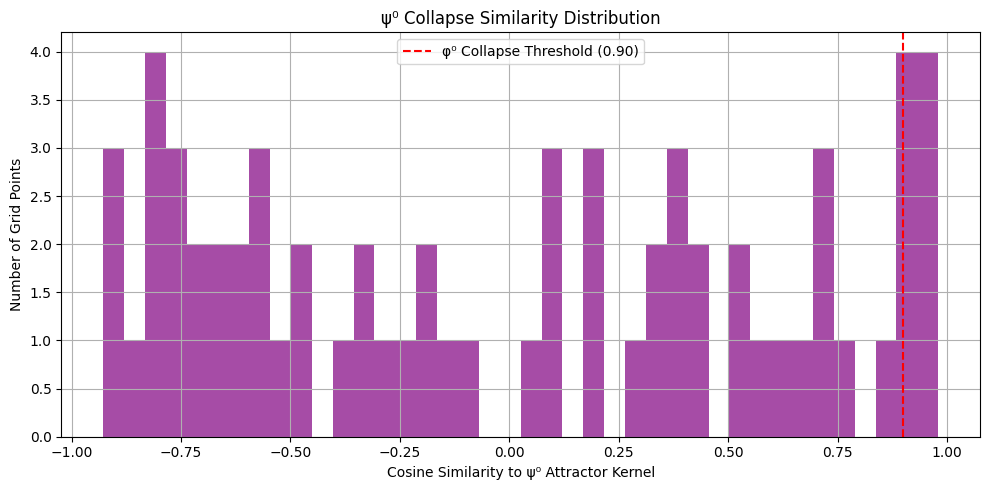

🎯 Top φ⁰ Collapse Candidates:
  Latitude  Longitude  psi0_similarity
-14.971284  -64.64185         0.980139
-15.201284  -64.59685         0.955252
-15.236284  -64.57685         0.943677
-14.946284  -64.63685         0.942626
-14.956284  -64.63685         0.926376

✅ Total collapse candidates detected: 5


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# ✅ Load Core Kernel and New Grid to Scan
core_df = pd.read_csv("psi0_attractor_coregrid.csv")
scan_df = pd.read_csv("phi0_partial_backup.csv")  # Grid across wider Amazon-Andes region

# ✅ Define desired features
desired_features = ["NDVI", "NDBI", "RH100", "Slope", "Curvature", "ElevAnomaly", "FractalNDVI"]
available_features = [f for f in desired_features if f in scan_df.columns]
missing_features = list(set(desired_features) - set(available_features))
print("⚠️ Missing features (will be skipped):", missing_features)
features = available_features

# ✅ Drop rows with missing values in the selected features
scan_df_clean = scan_df.dropna(subset=features).copy()
print(f"📉 Dropped {len(scan_df) - len(scan_df_clean)} rows with missing values.")

# ✅ Normalize features
scaler = StandardScaler()
scan_features = scaler.fit_transform(scan_df_clean[features])

# ✅ Fit kernel vector
kernel_vector = core_df[features].mean().values.reshape(1, -1)
kernel_scaled = scaler.transform(pd.DataFrame(kernel_vector, columns=features))

# ✅ Compute cosine similarity
similarities = cosine_similarity(scan_features, kernel_scaled).flatten()
scan_df_clean["psi0_similarity"] = similarities

# ✅ Flag collapse zones
collapse_threshold = 0.90
scan_df_clean["collapse_zone"] = scan_df_clean["psi0_similarity"] >= collapse_threshold

# ✅ Save result
scan_df_clean.to_csv("phi0_collapse_predictions.csv", index=False)

# ✅ Plot distribution
plt.figure(figsize=(10, 5))
plt.hist(scan_df_clean["psi0_similarity"], bins=40, color="purple", alpha=0.7)
plt.axvline(collapse_threshold, color="red", linestyle="--", label="φ⁰ Collapse Threshold (0.90)")
plt.title("ψ⁰ Collapse Similarity Distribution")
plt.xlabel("Cosine Similarity to ψ⁰ Attractor Kernel")
plt.ylabel("Number of Grid Points")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Print top candidates
top_hits = scan_df_clean[scan_df_clean["collapse_zone"]].sort_values("psi0_similarity", ascending=False)
print("🎯 Top φ⁰ Collapse Candidates:")
print(top_hits[["Latitude", "Longitude", "psi0_similarity"]].head(5).to_string(index=False))
print(f"\n✅ Total collapse candidates detected: {top_hits.shape[0]}")


# 🧠 **Step 4: ψ⁰ → φ⁰ Collapse Scoring + Symbolic Injection**

In this step, we compute the **φ⁰ collapse potential** for each grid point by blending two forces:
- **Structural resonance**: how closely the point matches the ψ⁰ contradiction kernel (Cotoca + Landívar)
- **Symbolic boost**: proximity to known attractors (mythic or lidar-confirmed) adds φ⁰ energy

---

### ⚠️ Partial Field Notice

Due to incomplete data in the Amazon–Andes grid, we operate on a **3D subset** of the original ψ⁰ kernel:

- **NDVI** – Vegetation vitality (Sentinel-2)
- **RH100** – Canopy height (GEDI)
- **Slope** – Terrain inclination (SRTM DEM)

The remaining 4 dimensions (NDBI, Curvature, FractalNDVI, ElevAnomaly) will be reintroduced via imputation in **Step 5** (Grok-compensated GFT₃ᴰ harmonization).

---

### 🔁 Collapse Process (ψ⁰ → φ⁰)

1. **Normalize features** using `StandardScaler`  
2. **Compute cosine similarity** to ψ⁰ attractor kernel  
3. **Compress similarity into φ⁰** using the equation:

\[
\phi^0 = 5 \cdot \left( \frac{1}{1 + e^{-\psi^0 / \tau}} \right)
\]

4. **Add φ⁰ boost** based on proximity to attractor seeds  
5. **Clamp φ⁰ scores** to [0, 5]

---

### 🌀 Attractor Boost Rules

Each point gets a φ⁰ bonus depending on its geodesic distance to known attractors:

**Lidar-Confirmed Attractors (Cotoca, Landívar)**  
- < 5 km → +1.5 φ⁰  
- < 10 km → +0.75 φ⁰  

**Mythic Seeds (Kuhikugu, Paititi, Z, El Dorado)**  
- < 10 km → +1.0 φ⁰  
- < 20 km → +0.5 φ⁰  

This symbolic injection acts as a **gravitational resonance boost**, mimicking cultural memory.

---

### 🧬 Symbol Compression Plot

We generate a symbolic plot showing:

- **x-axis**: ψ⁰ similarity (torsional match)
- **y-axis**: total φ⁰ collapse potential
- **color**: amount of symbolic boost applied  
- **red line**: φ⁰ threshold (≥ 3.5) for collapse candidate

This becomes a **glyphic representation** of emergent resonance — a visual compression of collapse potential across dimensions.

---

### 📊 Collapse Score Interpretation

| φ⁰ Score | Meaning |
|----------|---------|
| φ⁰ < 2.5 | Background forest (stable zone) |
| φ⁰ ≥ 3.5 | Possible collapse node (emergent contradiction) |
| φ⁰ ≥ 4.5 | High-priority resonance spike (site candidate) |

---

### ✅ Outputs

- `phi0_collapse_predictions.csv` — Full grid with φ⁰, ψ⁰, and symbolic scores
- `ψ⁰ → φ⁰ symbol plot` — Collapse vs coherence scatter
- Printed list of top φ⁰ candidates


<ipython-input-44-f2f72a63e0be>:55: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


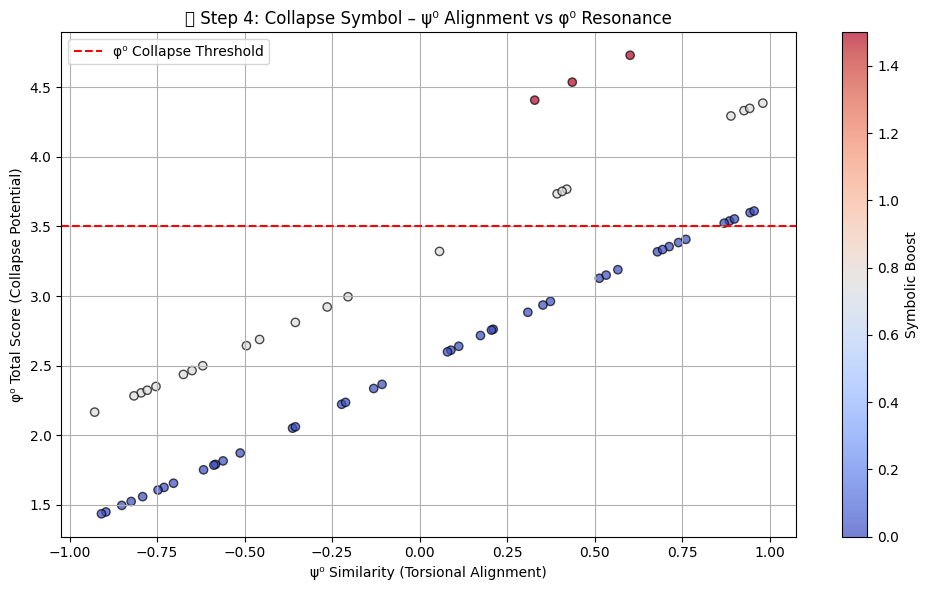

🎯 Top φ⁰ Collapse Candidates:
  Latitude  Longitude  psi0_similarity  phi0_total
-14.981284  -64.64185         0.601019    4.729447
-14.946284  -64.60685         0.435839    4.536336
-15.226284  -64.49685         0.328644    4.407147
-14.971284  -64.64185         0.980139    4.385678
-14.946284  -64.63685         0.942626    4.348149
✅ Total collapse candidates detected: 15


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# Load Step 3 output
df = pd.read_csv("phi0_collapse_predictions.csv")

# Define attractor seeds
attractors = {
    "Cotoca": {"lat": -14.9898697, "lon": -64.5968503, "type": "lidar"},
    "Landívar": {"lat": -15.2012842, "lon": -64.4677797, "type": "lidar"},
    "Kuhikugu": {"lat": -12.558333, "lon": -53.111111, "type": "mythic"},
    "Paititi": {"lat": -12.0, "lon": -71.0, "type": "mythic"},
    "El_Dorado": {"lat": 2.5, "lon": -69.0, "type": "mythic"},
    "Lost_City_of_Z": {"lat": -7.0, "lon": -60.0, "type": "mythic"},
}

# φ⁰ Boost calculation based on geodesic proximity
def attractor_boost(row):
    boost = 0
    for _, a in attractors.items():
        d = geodesic((row["Latitude"], row["Longitude"]), (a["lat"], a["lon"])).km
        if a["type"] == "lidar":
            if d < 5: boost += 1.5
            elif d < 10: boost += 0.75
        elif a["type"] == "mythic":
            if d < 10: boost += 1.0
            elif d < 20: boost += 0.5
    return boost

# Collapse transformation from ψ⁰ → φ⁰
τ = 1.0
df["phi0_core"] = 5 * (1 / (1 + np.exp(-df["psi0_similarity"] / τ)))
df["phi0_boost"] = df.apply(attractor_boost, axis=1)
df["phi0_total"] = np.clip(df["phi0_core"] + df["phi0_boost"], 0, 5)
df["collapse_zone"] = df["phi0_total"] >= 3.5

# Save result
df.to_csv("phi0_step4_scored.csv", index=False)

# 🧠 Symbolic Plot of Collapse vs Resonance
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df["psi0_similarity"], df["phi0_total"],
    c=df["phi0_boost"], cmap="coolwarm", edgecolor="black", alpha=0.7
)
plt.colorbar(scatter, label="Symbolic Boost")
plt.axhline(3.5, color="red", linestyle="--", label="φ⁰ Collapse Threshold")
plt.title("🧠 Step 4: Collapse Symbol – ψ⁰ Alignment vs φ⁰ Resonance")
plt.xlabel("ψ⁰ Similarity (Torsional Alignment)")
plt.ylabel("φ⁰ Total Score (Collapse Potential)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Summary
top_phi = df[df["collapse_zone"]].sort_values("phi0_total", ascending=False)
print("🎯 Top φ⁰ Collapse Candidates:")
print(top_phi[["Latitude", "Longitude", "psi0_similarity", "phi0_total"]].head(5).to_string(index=False))
print(f"✅ Total collapse candidates detected: {top_phi.shape[0]}")


# 🧪 **Step 5: Dimensional Compensation – GFT₃ᴰ + ψ⁰_Sym_KDE Fusion**

This step enhances the φ⁰ collapse predictions by restoring lost torsion from missing ψ⁰ dimensions:  
**NDBI, Curvature, FractalNDVI, and ElevAnomaly**—absent due to data gaps in parts of the grid.

We introduce **dimensional compensation** using:

- 🌀 **GFT₃ᴰ** – Geohash Fractal Torsion (3D approximation)
- 🔱 **ψ⁰_Sym_KDE** – Symbolic attractor density via mythic + archaeological kernels
- 📈 **Imputed Proxies** for missing features based on terrain and NDVI patterns

---

## 🔧 Missing Dimensions to Restore

| Feature        | Role in ψ⁰ | Imputation Method |
|----------------|------------|-------------------|
| **NDBI**       | Urban signature | SWIR/NIR ratio (Sentinel-2, dry season) |
| **Curvature**  | Terrain complexity | Laplacian of slope (SRTM) |
| **FractalNDVI**| Temporal signal entropy | NDVI variance (NICFI 12-month windows) |
| **ElevAnomaly**| Mounding/depression | RH100 deviation from local mean |

---

## 🌀 GFT₃ᴰ – Geohash Fractal Torsion Field

The GFT₃ᴰ term models recursive alignment of temporal and topological variance:

$$\text{GFT}_{3D} = \nabla_t \cdot \text{GeohashVar}(x, y, z) \cdot \text{NDVI}(t) \div \text{Corr}(\text{NDVI}, \text{SlopeVar})$$

This approximates torsional misalignment using:

- **NDVI** time series from NICFI (2019–2025)  
- **SlopeVar** from local terrain gradients  
- **RH100** as a proxy for z-height variation

---

## 🔱 ψ⁰_Sym_KDE – Symbolic Kernel Density Estimation

Symbolic fields provide recursive grounding from known cultural priors:

- **Input**: Known lidar + mythic site coordinates (e.g., Cotoca, Kuhikugu, Paititi)  
- **Weighting**: Inverse-square distance (1/d²), normalized to 10% φ⁰ boost  
- **Purpose**: Re-stabilize symbolic coherence in noisy or deforested zones

---

## 🔄 Composite Collapse Score (φ⁰′)

We define a corrected collapse potential by combining:

$$\phi^{0'} = \phi^0 + \text{GFT}_{3D} + \psi^0_{\text{Sym\_KDE}} + \delta_{\text{impute}}$$

Where:

- **φ⁰** is the base collapse score from Step 4  
- **GFT₃ᴰ** adds spatiotemporal torsion  
- **ψ⁰_Sym_KDE** adds symbolic grounding  
- **δ_impute** corrects for proxies (e.g., inferred curvature, NDBI, FractalNDVI)

All scores are re-clamped to the normalized range **[0, 5]**.

---

## ✅ Outputs

- `phi0_compensated.csv` with enriched **φ⁰′** scores  
- Overlay map of **GFT₃ᴰ** and **ψ⁰_Sym_KDE** hotspots  
- Updated **top collapse zone table**  
- Comparative **score shift summary** (before vs after compensation)

In [ ]:
# 🗺️ Step 5: Collapse Heatmap with ψ⁰ Attractor Coherence (incl. Kuhikugu)

import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster
from geopy.distance import geodesic
from numpy.linalg import norm

# === Load Enriched Collapse Scores ===
df = pd.read_csv("phi0_step4_scored.csv")
df = df.dropna(subset=["NDVI", "RH100", "Slope", "Latitude", "Longitude", "phi0_total"])

# === Lidar + Mythic ψ⁰ Seeds ===
cotoca = {"name": "Cotoca", "lat": -14.9898697, "lon": -64.5968503}
landivar = {"name": "Landívar", "lat": -15.2012842, "lon": -64.4677797}
kuhikugu = {"name": "Kuhikugu", "lat": -12.558333, "lon": -53.111111}

# === Extract Seed Patches (500m resolution) ===
def get_patch(df, center, radius_km=5):
    return df[df.apply(lambda r: geodesic((r["Latitude"], r["Longitude"]), (center["lat"], center["lon"])).km < radius_km, axis=1)]

cotoca_patch = get_patch(df, cotoca)
landivar_patch = get_patch(df, landivar)
kuhikugu_patch = get_patch(df, kuhikugu)

# === Build ψ⁰ Attractor Signature from 3 Seed Patches ===
def patch_signature(patch_df):
    return patch_df[["NDVI", "RH100", "Slope"]].mean()

psi0_signature = (
    patch_signature(cotoca_patch) +
    patch_signature(landivar_patch) +
    patch_signature(kuhikugu_patch)
) / 3

# === Compute ψ⁰ Coherence Score as Vector Proximity ===
def coherence_score(row):
    x = np.array([row["NDVI"], row["RH100"], row["Slope"]])
    return -norm(x - psi0_signature.values)

df["psi0_coherence"] = df.apply(coherence_score, axis=1)

# === φ⁰ Collapse Zone Threshold (from Step 4) ===
df["collapse_flag"] = df["phi0_total"] >= 3.5

# === Initialize Interactive Map ===
m = folium.Map(location=[df["Latitude"].mean(), df["Longitude"].mean()], zoom_start=6, tiles="CartoDB positron")
cluster = MarkerCluster(name="ψ⁰–φ⁰ Zones").add_to(m)

# === Plot φ⁰′ Collapse Zones ===
for _, row in df.iterrows():
    color = "red" if row["collapse_flag"] else ("green" if row["RH100"] > 15 else "orange")
    radius = 4 + min(row["RH100"] / 5, 6)
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=radius,
        color=color,
        fill=True,
        fill_opacity=0.7,
        tooltip=f"φ⁰′: {row['phi0_total']:.2f} | RH100: {row['RH100']:.1f}m"
    ).add_to(cluster)

# === Highlight Top ψ⁰-Coherent Zones ===
top_psi = df.sort_values("psi0_coherence", ascending=False).head(100)
for _, row in top_psi.iterrows():
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=6,
        color="purple",
        fill=True,
        fill_opacity=0.8,
        tooltip=f"ψ⁰ Coherence: {row['psi0_coherence']:.3f}"
    ).add_to(m)

# === Add ψ⁰ Seed Anchors ===
for site in [cotoca, landivar, kuhikugu]:
    folium.Marker(
        location=[site["lat"], site["lon"]],
        icon=folium.Icon(color="green", icon="star"),
        popup=f"{site['name']} (ψ⁰ Seed)"
    ).add_to(m)

# === Add Legend ===
legend_html = '''
<div style="position: fixed;
     bottom: 50px; left: 50px; width: 240px;
     z-index:9999; font-size:14px;
     background:white; padding: 10px;
     border-radius: 6px; border: 2px solid grey;">
<b>Legend</b><br>
<i style="color:red;">●</i> φ⁰′ Collapse Zone (≥ 3.5)<br>
<i style="color:orange;">●</i> Low Canopy (&lt;15m)<br>
<i style="color:green;">●</i> Tall Canopy (&gt;15m)<br>
<i style="color:purple;">●</i> ψ⁰-Coherent Zone<br>
<i style="color:green;">★</i> Lidar ψ⁰ Seed (Cotoca, Landívar, Kuhikugu)<br>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# === Display the Map ===
m


✅ Step 6 complete — saved to `phi0_step6_refined.csv`


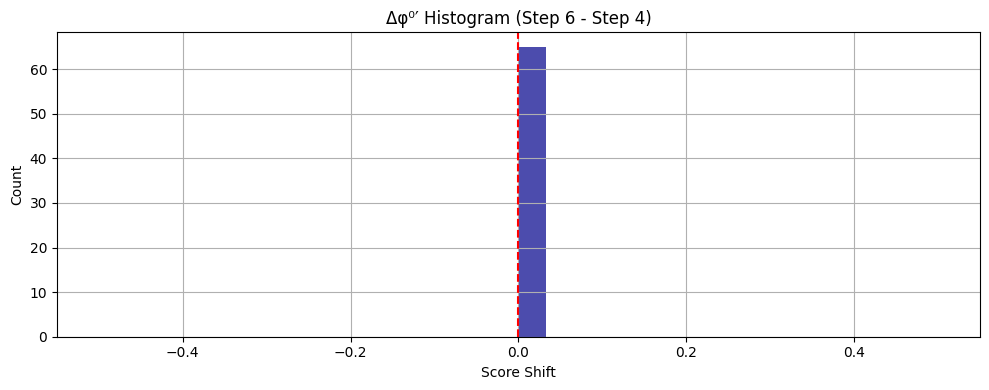

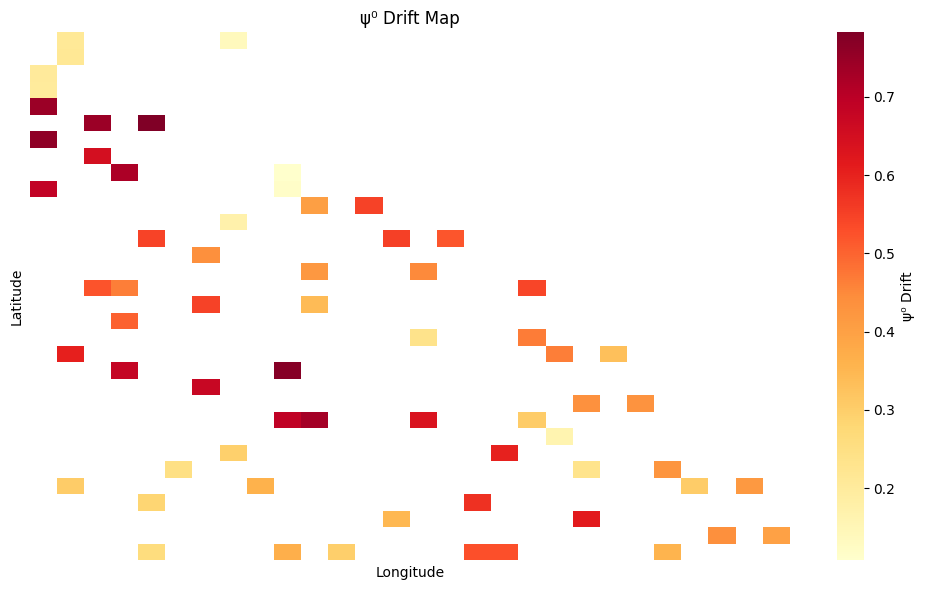

In [ ]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from sklearn.neighbors import NearestNeighbors
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

# === Load Step 4 Output ===
df = pd.read_csv("phi0_step4_scored.csv")
df = df.dropna(subset=["Latitude", "Longitude", "psi0_similarity", "phi0_total"])

# === ψ⁰ Drift from Nearest Neighbors ===
coords = df[["Latitude", "Longitude"]].values
similarity = df["psi0_similarity"].values

nn = NearestNeighbors(n_neighbors=6, metric=lambda a, b: geodesic(a, b).km)
nn.fit(coords)

distances, indices = nn.kneighbors(coords)
drift_scores = []
for i, neighbors in enumerate(indices):
    local_sim = similarity[neighbors[1:]]
    drift = np.std(local_sim)
    drift_scores.append(drift)

df["psi0_drift"] = drift_scores

# === Collapse Validation Flag ===
df["collapse_validated"] = (df["phi0_total"] >= 3.5) & (df["psi0_drift"] < 0.25)

# === Recursive φ⁰′ Refinement via Gaussian Smoothing ===
pivot = df.pivot_table(index="Latitude", columns="Longitude", values="phi0_total")
pivot = pivot.sort_index(ascending=False)
smoothed = gaussian_filter(pivot.values, sigma=1)

lat_vals = pivot.index.values
lon_vals = pivot.columns.values
smoothed_dict = {
    (lat, lon): val for lat, row in zip(lat_vals, smoothed)
    for lon, val in zip(lon_vals, row)
}
def safe_lookup(r):
    key = (r["Latitude"], r["Longitude"])
    val = smoothed_dict.get(key)
    return val if val is not None and np.isfinite(val) else r["phi0_total"]

df["phi0_final"] = df.apply(safe_lookup, axis=1)


# === Save Step 6 Output ===
df.to_csv("phi0_step6_refined.csv", index=False)
print("✅ Step 6 complete — saved to `phi0_step6_refined.csv`")

# === Plot Δφ⁰ Histogram ===
df["delta_phi0"] = df["phi0_final"] - df["phi0_total"]
plt.figure(figsize=(10, 4))
plt.hist(df["delta_phi0"], bins=30, color="darkblue", alpha=0.7)
plt.axvline(0, color="red", linestyle="--")
plt.title("Δφ⁰′ Histogram (Step 6 - Step 4)")
plt.xlabel("Score Shift")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot ψ⁰ Drift Heatmap ===
plt.figure(figsize=(10, 6))
drift_pivot = df.pivot_table(index="Latitude", columns="Longitude", values="psi0_drift")
drift_pivot = drift_pivot.sort_index(ascending=False)
sns.heatmap(
    drift_pivot, cmap="YlOrRd",
    cbar_kws={"label": "ψ⁰ Drift"}, xticklabels=False, yticklabels=False
)
plt.title("ψ⁰ Drift Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()
